# Phần 1: Thư viện

- **re**: Xử lý chuỗi với các biểu thức chính quy
- **demoji**: Biểu tượng cảm xúc
- **pickle**: Lưu trữ và truy xuất dữ liệu
- **numpy**: Tính toán 
- **pandas**: Cấu trúc dữ liệu và công cụ phân tích dữ liệu 
- **matplotlib.pyplot**: Biểu đồ trong Python
- **tensorflow**: Xây dựng và huấn luyện mô hình học máy
- **scikit-learn**: Các công cụ cho việc học máy và thống kê
- **pyvi**: Thư viện tiếng Việt hóa văn bản

In [3]:
import re
import demoji
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D, ELU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pyvi import ViTokenizer, ViUtils

demoji.download_codes()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10708\2947115676.py:17: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


# Phần 2: Xử lý dữ liệu

Nhập liệu

In [4]:
data = pd.read_csv('data_modified.csv')
missing_values = data.isnull().sum()


print(f"Số lượng hàng: {data.shape[0]}")
print(f"Số lượng cột: {data.shape[1]}")
print(f"Tên cột: {list(data.columns)}")
print(f"Thông tin cột bị thiếu: \n{missing_values}")
data.info()

sentiment_data = data

Số lượng hàng: 31460
Số lượng cột: 2
Tên cột: ['comment', 'label']
Thông tin cột bị thiếu: 
comment    0
label      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


Tiền xử lý 

In [5]:
def remove_emo(text):
    emo = demoji.replace(text, '')
    return emo

# Loại bỏ URL
def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text

# Loại bỏ tên người và địa chỉ email
def remove_mentions_and_emails(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    return text

In [6]:
input_data = sentiment_data['comment'].values
input_label = sentiment_data['label'].values

label_dict = {'NEG':0,'NEU':1,'POS':2}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
    #Chuyển đổi thành list
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    # Chuyển danh sách từ 1 chuỗi
    input_text_pre = " ".join(input_text_pre)

    # Tiền xử lý dữ liệu
    input_text_pre = remove_emo(input_text_pre)     # Loại bỏ emoji
    input_text_pre = remove_urls(input_text_pre)       # Loại bỏ url 
    input_text_pre = remove_mentions_and_emails(input_text_pre)     # Loại bỏ email và tên người

    # Tách dấu
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))

    # Tách từ
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)

    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])
input_pre

['áo bao đẹp ạ',
 'ao bao dep a',
 'tuyệt_vời',
 'tuyet voi',
 '2day ao khong giong trong',
 '2day ao khong giong trong',
 'mùi thơm bôi lên da mềm da',
 'mui thom boi len da mem da',
 'vải đẹp dày_dặn',
 'vai dep day dan',
 'hàng rất đẹp rất chi là ưng_ý',
 'hang rat dep rat chi la_ung y',
 'chất_lượng sản_phẩm tốt date dài',
 'chat luong san pham tot date dai',
 'ăn_nói và thái_độ phục_vụ tốt',
 'an noi va thai do phuc vu tot',
 'đóng_gói sản_phẩm chắc_chắn',
 'dong goi san pham chac chan',
 'tất sờn hết ca chưa dùng mà vay r',
 'tat son het ca chua dung ma vay r',
 'shop phục_vụ rất tốt',
 'shop phuc vu rat tot',
 'mặc thì cũng đc',
 'mac thi cung dc',
 'chất vải khỏi chê',
 'chat vai khoi che',
 'thời_gian giao hàng rất nhanh',
 'thoi gian giao hang rat nhanh',
 'chất_lượng sản_phẩm tuyệt_vời',
 'chat luong san pham tuyet voi',
 'vải hơi thô cứng thời_gian giao hàng nhanh',
 'vai hoi tho cung thoi gian giao hang_nhanh',
 'chất_lượng sp chưa thật_sự đẹp nhe shop',
 'chat luong sp ch

Biểu đồ histogram dữ liệu từ 0 đến 31k

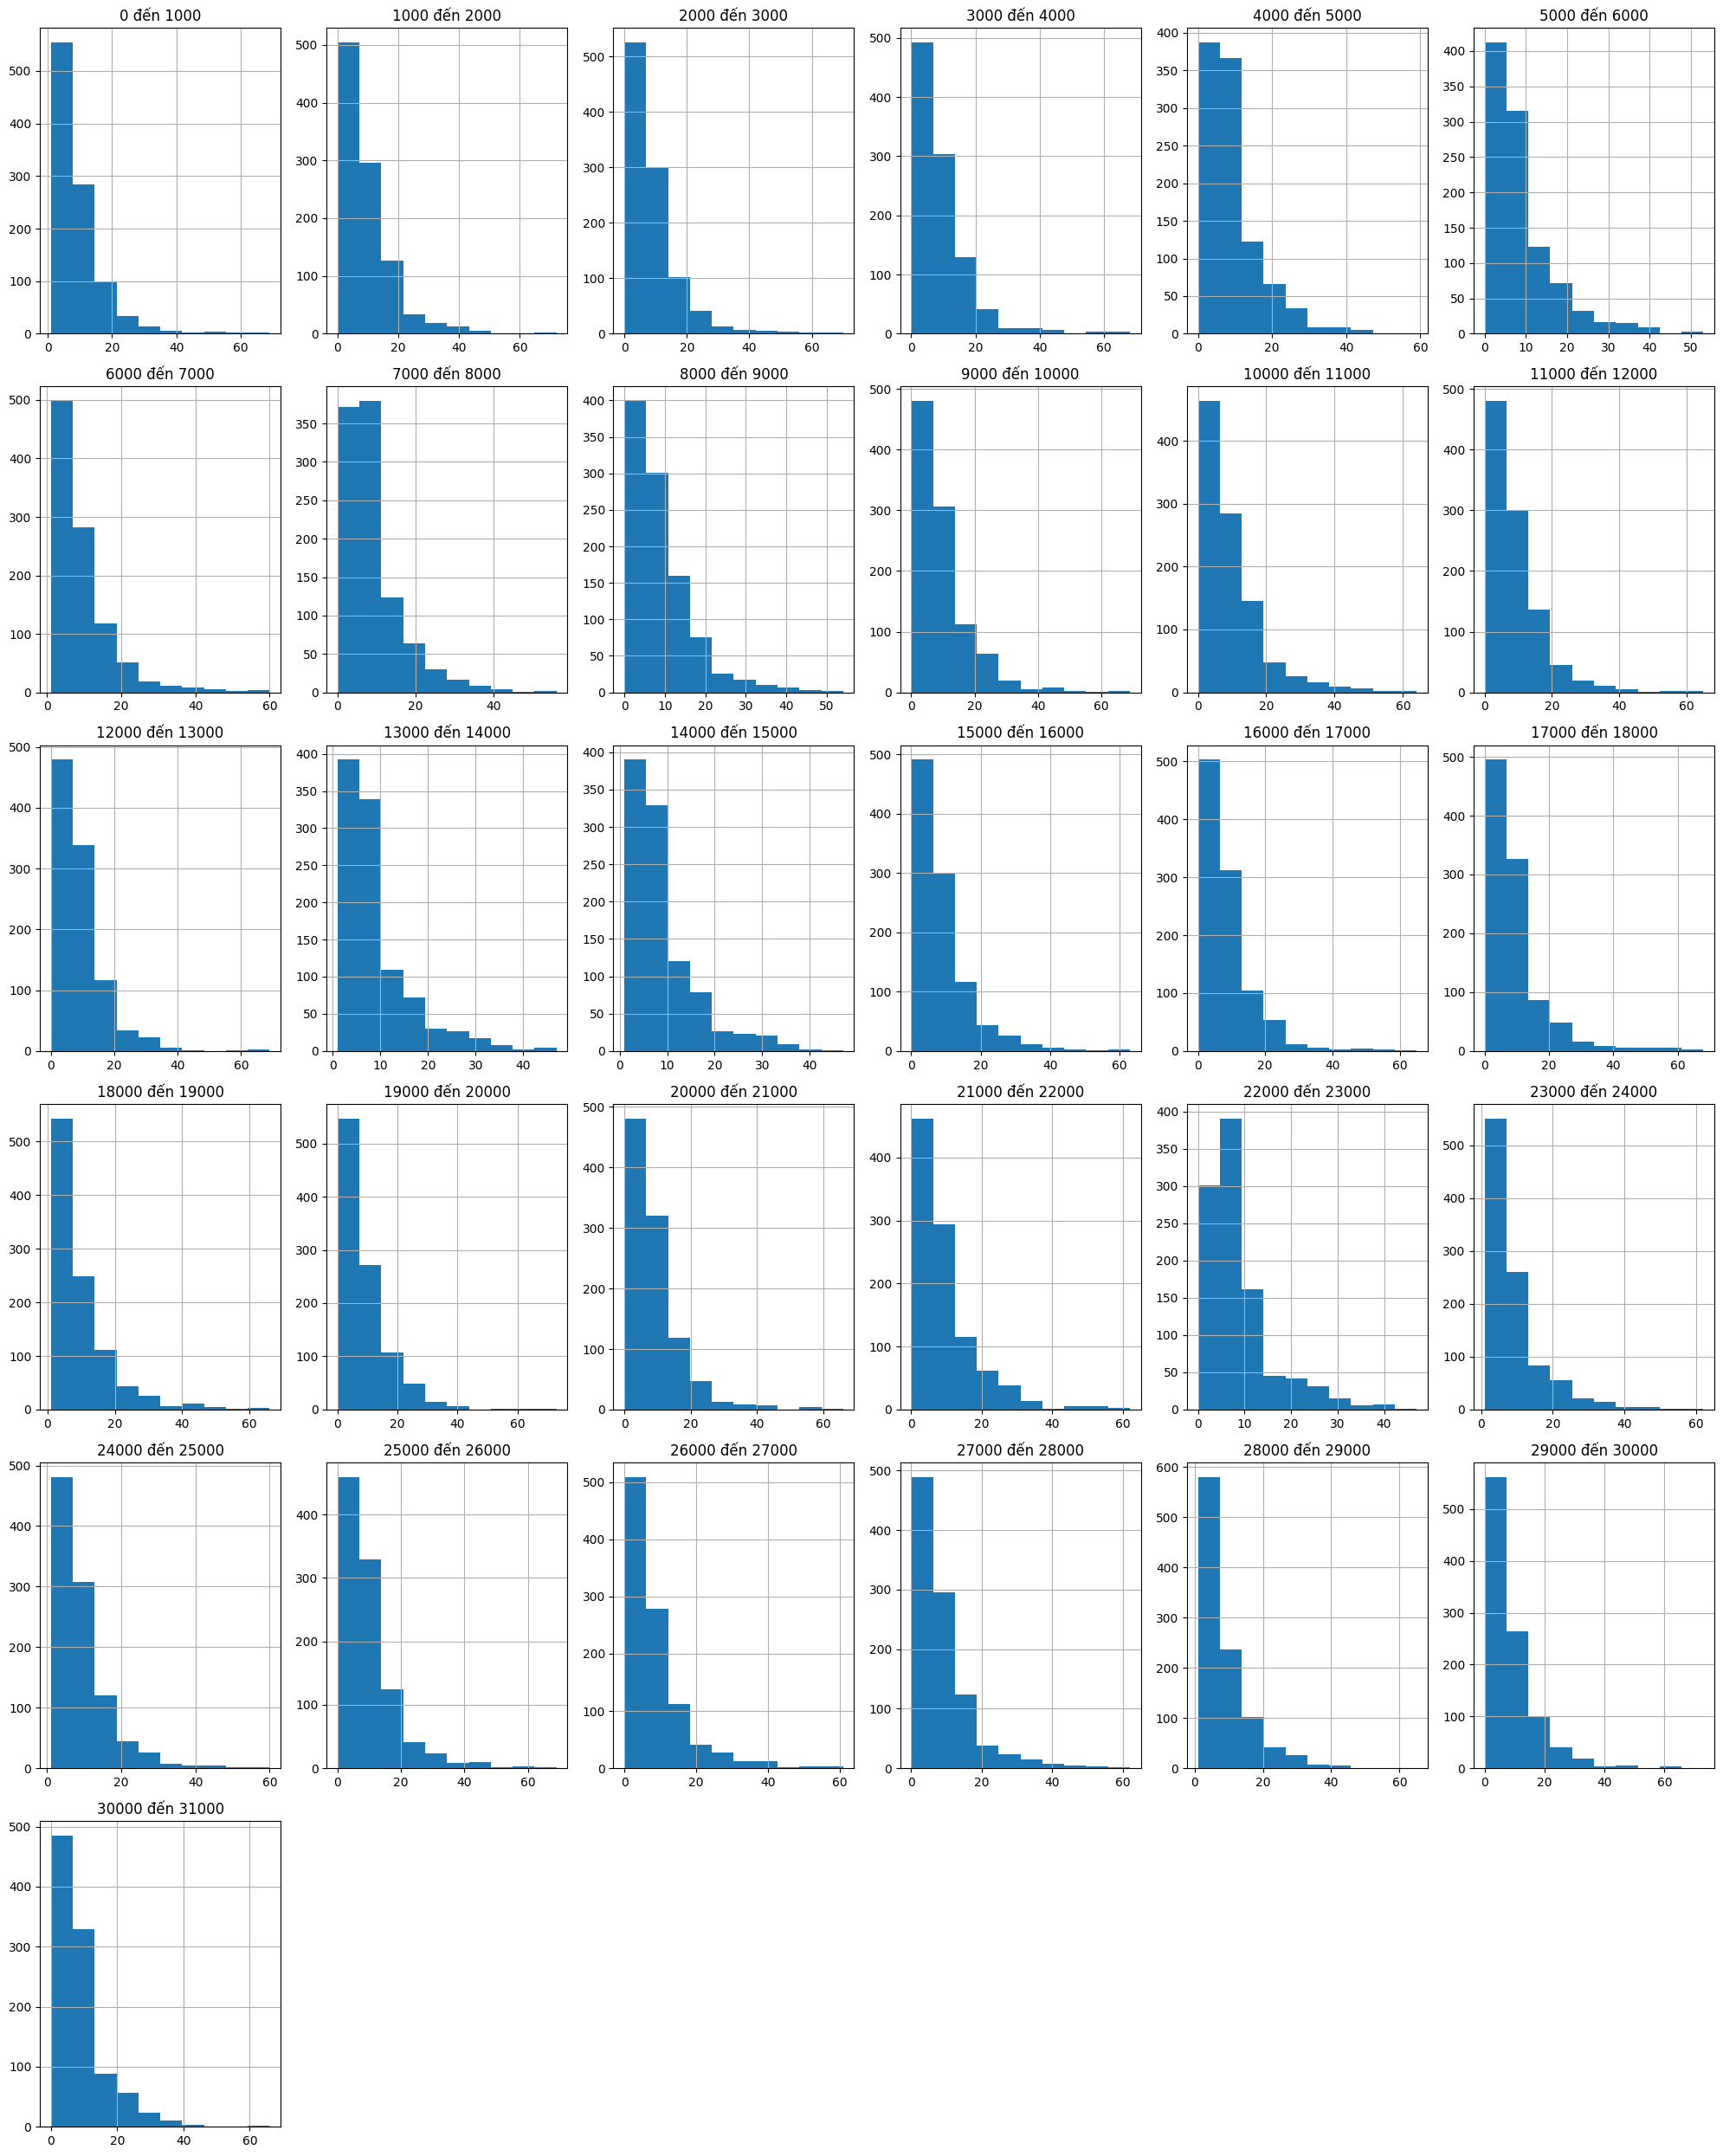

In [7]:
bin_count = 10  # Số lượng bin
chunk_size = 1000   # Kích thước của mỗi phân đoạn
total_chunks = 31000 // chunk_size      # Tổng số phân đoạn

# Tạo 1 figure mới
fig, axes = plt.subplots(nrows=(total_chunks // 6) + (1 if total_chunks % 6 != 0 else 0), ncols=6, figsize=(20, (total_chunks // 6) * 5))

for i, ax in zip(range(0, 31000, chunk_size), axes.flatten()):
    seq_len = [len(sentence.split()) for sentence in input_pre[i:i+chunk_size]]     # Tính độ dài của từng câu
    pd.Series(seq_len).hist(bins=bin_count, ax=ax)      # Vẽ histogram
    ax.set_title(f'{i} đến {i+chunk_size}')     # Tiêu đề

# Xóa các trục con thừa
for j in range(total_chunks, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [8]:
# chuyển đổi các nhãn từ dạng chuỗi sang dạng số
label_idx = [label_dict[i] for i in label_with_accent]
# mã hóa one-hot
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3)
label_tf = label_tf.astype('float32')

# xử lý văn bản thành các chuỗi số và đệm
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')    # tạo từu khóa OOV, không lọc ký tự cách từ = dấu cách
tokenizer_data.fit_on_texts(input_pre)  # học từ điển từ danh sách đã tiền xử lý
 
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)      # vb => chuỗi số
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=512) # đệm chuỗi số sang dạng cố định 512

#lưu tokenizer
pickle.dump(tokenizer_data, open("tokenizer_data.pkl","wb"))

print(f"Kích thước dữ liệu đầu vào: {vec_data.shape}")
data_vocab_size = len(tokenizer_data.word_index)+1  # kích thước từ điển + từ khóa OOV
print(f"Kích thước của từ điển: {data_vocab_size}")

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Số mẫu trong tập huấn luyện: {len(X_train)}")
print(f"Số mẫu trong tập validation: {len(X_val)}")
print(f"Số mẫu trong tập kiểm tra: {len(X_test)}")


Kích thước dữ liệu đầu vào: (62920, 512)
Kích thước của từ điển: 9777
Số mẫu trong tập huấn luyện: 45302
Số mẫu trong tập validation: 12584
Số mẫu trong tập kiểm tra: 5034


# Phần 3: Train model

In [9]:
def generate_model():
    dropout_threshold = 0.4     # Ngưỡng dropout
    input_dim = data_vocab_size     # Kích thước từ vựng
    output_dim = 32     # Kích thước của vector embedding
    input_length = 512  # Độ dài tối đa
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    # chuyển đổi từ khóa vào vector
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)

    # CNN để trích xuất đặc trưng
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Mạng Bi-directional LSTM và GRU để xử lý tuần tự dữ liệu
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Kết hợp đặc trưng từ CNN và Bi-LSTM/GRU
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Các lớp Dense (MLP) để phân loại
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(10, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)     # Lớp đầu ra với 3 lớp, dùng softmax để phân loại

    # Tạo mô hình Keras
    model = Model(inputs=input_layer, outputs=classifier)

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)       # Trình tối ưu Adam với learning rate 0.001
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])        # Hàm mất mát categorical crossentropy và metric accuracy
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 512, 32)   │    312,864 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 32)   │      3,104 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 256, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512, 64)   │     16,640 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 32)   │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 256, 64)   │          0 │ bidirectional[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 128, 32)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256, 64)   │     18,816 │ max_pooling1d_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 32)   │         64 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 128, 64)   │          0 │ bidirectional_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ max_pooling1d_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 96)   │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ global_max_pooli… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │      8,730 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 375,435 (1.43 MB)

 Trainable params: 375,435 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện

In [31]:
# Định nghĩa callback để lưu mô hình
callback_model = tf.keras.callbacks.ModelCheckpoint(
    'model_cnn_bilstm.keras',
    monitor='val_loss',
    save_best_only=True  # Chỉ lưu mô hình tốt nhất
)

# Huấn luyện mô hình
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[callback_model]
)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.6902 - loss: 0.6904 - val_accuracy: 0.7854 - val_loss: 0.5394
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7838 - loss: 0.5676 - val_accuracy: 0.7898 - val_loss: 0.5239
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.7932 - loss: 0.5284 - val_accuracy: 0.7910 - val_loss: 0.5141
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 351s 992ms/step - accuracy: 0.8050 - loss: 0.4886 - val_accuracy: 0.7945 - val_loss: 0.5083
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 339s 957ms/step - accuracy: 0.8124 - loss: 0.4756 - val_accuracy: 0.7951 - val_loss: 0.5278
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8203 - loss: 0.4547 - val_accuracy: 0.7968 - val_loss: 0.5218
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.8259 - loss: 0.4500 - val_accuracy: 0.7975 - val_loss: 0.5224
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 339s 959ms/step - accuracy: 0.8365 - loss: 0.4253 -

In [32]:
model.load_weights("model_cnn_bilstm.keras")
model.evaluate(X_test,y_test)

158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7902 - loss: 0.5010


[0.501426637172699, 0.7932062149047852]

# Phần 4: Chạy Model

In [10]:
# Hàm tiền xử lý đầu vào văn bản th
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print(f"Comment: {input_text_pre_accent}")
    tokenizer_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=512)
    return vec_data

# Hàm này nhận đầu vào đã tiền xử lý và mô hình để thực hiện suy diễn và trả về kết quả dự đoán
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]    # Dự đoán bằng mô hình
    result = output.argmax()        # Lấy nhãn có xác suất cao nhất
    conf = float(output.max())  
    label_dict = {'NEG': 0, 'NEU': 1, 'POS': 2}         # Từ điển các nhãn
    label = list(label_dict.keys())
    return label[int(result)], conf

# Hàm  kết hợp tiền xử lý và suy diễn 
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)        # Tiền xử lý đầu vào
    # Dự đoán kết quả
    result, conf = inference_model(input_model, model)
    return result, conf

# Tạo và tải mô hình
my_model = generate_model()
my_model = load_model('model_cnn_bilstm.keras')

# Tải tokenizer từ file
with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Ví dụ
raw_input_example = "fí đắt quá không mua nổi"
result, confidence = prediction(raw_input_example, my_tokenizer, my_model)
print(f"Result: {result}, Confidence: {confidence}")


Comment: fí đắt quá không mua nổi
Result: NEG, Confidence: 0.7741016149520874


In [ ]:
while True:
    text = input()
    if text == 'end':
        break
    else:
        print(prediction(text, my_tokenizer, my_model)[0]+"\n")